# Speciation Transition

[GMM] Added .sample(n, seed) method.


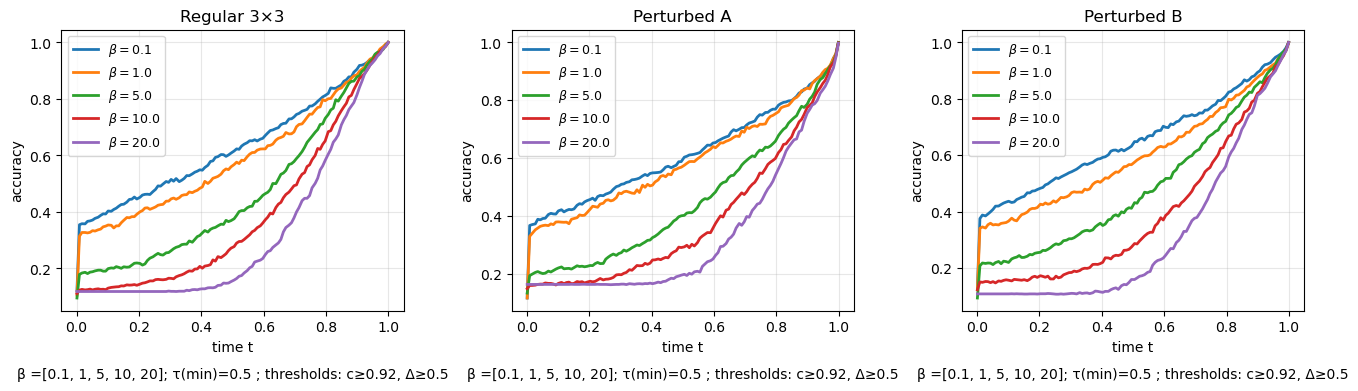

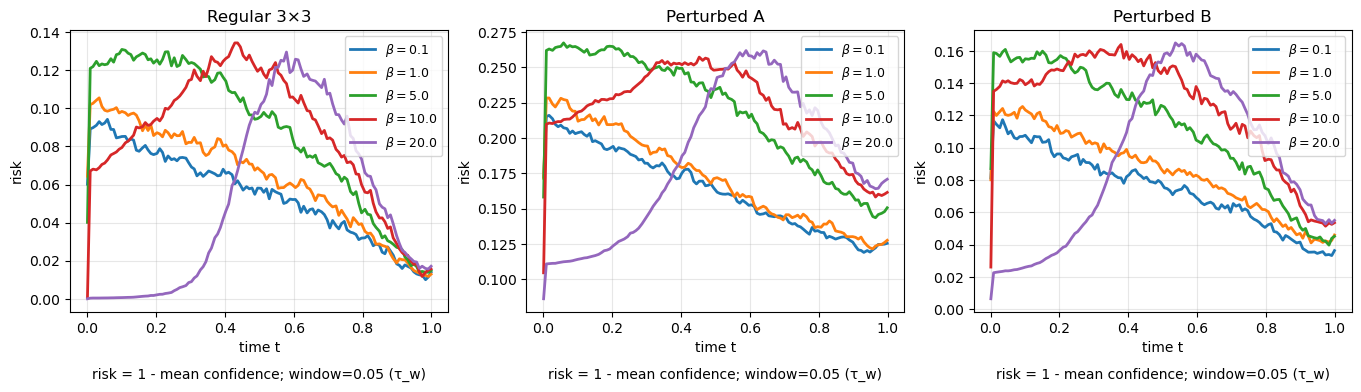

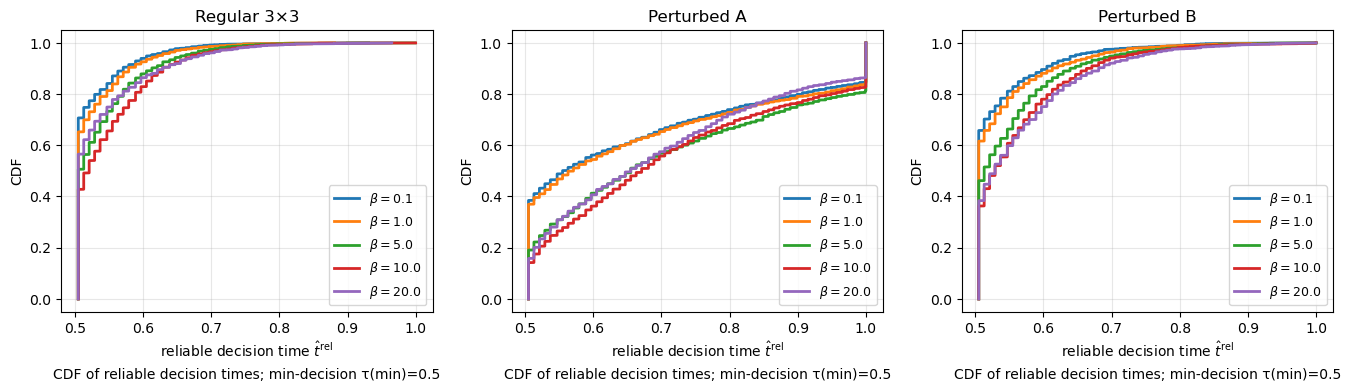

[saved] figs/speciation_acc_vs_time_multi_beta.png
[saved] figs/speciation_risk_vs_time_multi_beta.png
[saved] figs/speciation_trel_cdf_multi_beta.png


In [1]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)


# ============================================================
# Speciation (early label) identification with min decision time τ
# MULTI-β VERSION (β ∈ {0.1, 1, 5, 10, 20}) — three models
#   • Each plot shows 5 β curves in distinct colors
#   • Adds t_min_decision = τ (default 0.5): no stopping allowed before τ
#   • Shorter titles; details below x-axis at y=-0.2, fontsize=10
#
# Prereqs in the notebook:
#   - GMM, sample_gmm(gmm, M, rng)
#   - yhat_oracle_gmm(X, t, sched, gmm)
#   - BetaSchedulePWC
#   - alpha_K_gamma_from_schedule
# ============================================================
import numpy as np, math, os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

os.makedirs("figs", exist_ok=True)

# ------------------------ helpers: responsibilities & entropy ------------------------
def gmm_resp(Y, MU, SIG, PI):
    """Return responsibilities r_k(y) for isotropic GMM."""
    Y = np.atleast_2d(Y).astype(float)     # (N,d)
    MU = np.asarray(MU, float)             # (K,d)
    SIG= np.asarray(SIG, float)            # (K,)
    PI = np.asarray(PI, float)             # (K,)
    N, d = Y.shape
    dx = Y[:,None,:] - MU[None,:,:]        # (N,K,d)
    invs2 = 1.0 / (SIG**2)                 # (K,)
    log_comp = (np.log(PI)[None,:]
                - 0.5*d*np.log(2*np.pi*(SIG**2))[None,:]
                - 0.5*np.sum(dx*dx, axis=2)*invs2[None,:])   # (N,K)
    m = np.max(log_comp, axis=1, keepdims=True)
    w = np.exp(log_comp - m)
    Z = np.sum(w, axis=1, keepdims=True)
    r = w / np.clip(Z, 1e-300, None)
    return r

def entropy_rows(P):
    P = np.clip(P, 1e-12, 1.0)
    return -np.sum(P*np.log(P), axis=1)

def top2_margin(P):
    s = -np.sort(-P, axis=1)
    return s[:,0] - s[:,1]

# ------------------------ simulation with fixed β ------------------------
def simulate_and_collect(gmm, beta=1.0, M=4000, T=1200, seed=0, eval_points=100):
    """
    Midpoint EM with unit diffusion, X(0)~N(0, I).
    Returns: times (E,), X_list (E×M×d), Yhat_list (E×M×d)
    """
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    d   = gmm.d
    X   = rng.normal(size=(M, d))
    sched = BetaSchedulePWC.constant(float(beta))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)  # interior sanity

    # evaluation indices (shared across β by using same eval_points)
    idx = np.linspace(0, T-1, int(min(max(5, eval_points), T))).round().astype(int)
    idx = np.unique(np.clip(idx, 0, T-1))
    times = (idx + 0.5) / T

    X_list, Yhat_list = [], []
    idx_set = set(idx.tolist())

    for n in range(T):
        t_mid = (n + 0.5) / T
        yhat  = yhat_oracle_gmm(X, float(t_mid), sched, gmm)
        a_m   = float(sched.a_minus(float(t_mid)))
        b_m   = float(sched.b_minus(float(t_mid)))
        u     = b_m*yhat - a_m*X

        if n in idx_set:
            X_list.append(X.copy()); Yhat_list.append(yhat.copy())

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return times, X_list, Yhat_list

# ------------------------ decision-time with min t (τ) ------------------------
def decision_times_with_min_t(gmm, times, Yhat_list, X_list,
                              c_thr=0.92, d_thr=0.5, H_thr=None,
                              t_min_decision=0.5, tau_window=0.05):
    """
    Reliable decision time per particle with a hard minimum time:
      - No decision allowed at t < t_min_decision
      - Stability: label constant on a trailing window of length tau_window
    Returns: t_rel (M,), ell_rel (M,), ell_oracle (M,), Acc(t), Risk(t)
    """
    M, d = X_list[-1].shape
    if H_thr is None:
        p = float(c_thr)  # entropy of (p,1-p)
        H_thr = -(p*np.log(p) + (1-p)*np.log(1-p))

    E = len(times)
    dt_e = float(times[1] - times[0]) if E > 1 else 1.0
    first_allowed = int(np.searchsorted(times, float(t_min_decision), side="left"))
    W = max(2, int(round(float(tau_window) / max(dt_e, 1e-9))))

    # terminal oracle labels from X(1) under target posterior
    X_T = X_list[-1]
    r_term = gmm_resp(X_T, gmm.MU, gmm.SIG, gmm.PI)
    ell_oracle = np.argmax(r_term, axis=1)

    Acc_t  = np.zeros(E, float)
    Risk_t = np.zeros(E, float)

    labels_pred = np.empty((E, M), int)
    conf_pred   = np.empty((E, M), float)
    marg_pred   = np.empty((E, M), float)
    entr_pred   = np.empty((E, M), float)

    for e, t in enumerate(times):
        r_pred = gmm_resp(Yhat_list[e], gmm.MU, gmm.SIG, gmm.PI)   # (M,K)
        labels_pred[e] = np.argmax(r_pred, axis=1)
        conf_pred[e]   = r_pred[np.arange(M), labels_pred[e]]
        marg_pred[e]   = top2_margin(r_pred)
        entr_pred[e]   = entropy_rows(r_pred)
        Acc_t[e]  = np.mean(labels_pred[e] == ell_oracle)
        Risk_t[e] = 1.0 - np.mean(conf_pred[e])

    t_rel  = np.full(M, np.nan, float)
    ell_rel= np.full(M, -1, int)
    for m in range(M):
        decided = False
        for e in range(first_allowed, E):
            s0 = max(0, e - W + 1)
            seq = labels_pred[s0:e+1, m]
            if np.all(seq == seq[-1]):
                if (conf_pred[e, m] >= c_thr and
                    marg_pred[e, m] >= d_thr and
                    entr_pred[e, m] <= H_thr):
                    t_rel[m]   = times[e]
                    ell_rel[m] = seq[-1]
                    decided = True
                    break
        if not decided:
            t_rel[m]   = 1.0
            ell_rel[m] = labels_pred[-1, m]

    return t_rel, ell_rel, ell_oracle, Acc_t, Risk_t

# ------------------------ ROC/AUC & calibration utilities (optional) ------------------------
def roc_auc_top2_at(e_idx, Yhat_list, gmm, ell_oracle):
    r = gmm_resp(Yhat_list[e_idx], gmm.MU, gmm.SIG, gmm.PI)
    s = -np.sort(-r, axis=1)
    margin = s[:,0] - s[:,1]
    yhat = np.argmax(r, axis=1)
    acc  = (yhat == ell_oracle).astype(int)  # "correct" as positive
    fpr, tpr, _ = roc_curve(acc, margin)
    return auc(fpr, tpr)

def ece_at(e_idx, Yhat_list, gmm, ell_oracle, n_bins=12):
    r = gmm_resp(Yhat_list[e_idx], gmm.MU, gmm.SIG, gmm.PI)
    conf = np.max(r, axis=1)
    yhat = np.argmax(r, axis=1)
    acc  = (yhat == ell_oracle).astype(float)
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    for b in range(n_bins):
        m = (conf >= bins[b]) & (conf < bins[b+1])
        if np.any(m):
            ece += np.abs(acc[m].mean() - conf[m].mean()) * (m.mean())
    return float(ece)

# ------------------------ experiment driver (multi-β) ------------------------
def speciation_multi_beta_three_models(beta_list=(0.1, 1.0, 5.0, 10.0, 20.0),
                                       M=2000, T=500, seed=20241012,
                                       eval_points=120,
                                       c_thr=0.92, d_thr=0.5, H_thr=None,
                                       tau=0.5, tau_window=0.05):
    """
    Run three GMMs (Regular, Perturbed A/B) for multiple β values.
    Produces three figures (accuracy, risk, CDF), each with 3 subplots (one per model),
    and 5 colored curves (one per β).
    """
    models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_map = {float(b): colors[i % len(colors)] for i, b in enumerate(beta_list)}

    # set up figures
    fig_acc, axs_acc = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)
    fig_risk, axs_rk = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)
    fig_cdf,  axs_cdf= plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

    # run each model × β
    for j, (name, gmm) in enumerate(models):
        legends_done = False
        for i, b in enumerate(beta_list):
            # simulate
            times, X_list, Yhat_list = simulate_and_collect(
                gmm, beta=float(b), M=M, T=T, seed=seed + 37*j + 1009*i, eval_points=eval_points
            )
            # decisions
            t_rel, ell_rel, ell_oracle, Acc_t, Risk_t = decision_times_with_min_t(
                gmm, times, Yhat_list, X_list,
                c_thr=c_thr, d_thr=d_thr, H_thr=H_thr,
                t_min_decision=float(tau), tau_window=tau_window
            )

            # (optional) mid-time diagnostics
            # e_mid = int(round(0.5*(len(times)-1)))
            # AUC_mid = roc_auc_top2_at(e_mid, Yhat_list, gmm, ell_oracle)
            # ECE_mid = ece_at(e_mid, Yhat_list, gmm, ell_oracle, n_bins=12)

            # ---- plot Acc(t) ----
            axs_acc[j].plot(times, Acc_t, lw=2.0, color=color_map[float(b)],
                            label=r"$\beta={}$".format(b))
            axs_acc[j].set_title(name)
            axs_acc[j].set_xlabel("time t"); axs_acc[j].set_ylabel("accuracy")
            axs_acc[j].grid(True, alpha=0.3)

            # ---- plot Risk(t) ----
            axs_rk[j].plot(times, Risk_t, lw=2.0, color=color_map[float(b)],
                           label=r"$\beta={}$".format(b))
            axs_rk[j].set_title(name)
            axs_rk[j].set_xlabel("time t"); axs_rk[j].set_ylabel("risk")
            axs_rk[j].grid(True, alpha=0.3)

            # ---- plot CDF(t_rel) ----
            t_sorted = np.sort(t_rel)
            cdf = np.linspace(0, 1, len(t_sorted), endpoint=True)
            axs_cdf[j].plot(t_sorted, cdf, lw=2.0, color=color_map[float(b)],
                            label=r"$\beta={}$".format(b))
            axs_cdf[j].set_title(name)
            axs_cdf[j].set_xlabel(r"reliable decision time $\hat t^{\rm rel}$"); axs_cdf[j].set_ylabel("CDF")
            axs_cdf[j].grid(True, alpha=0.3)

        # legends for each model’s column
        axs_acc[j].legend(frameon=True, fontsize=9)
        axs_rk[j].legend(frameon=True, fontsize=9)
        axs_cdf[j].legend(frameon=True, fontsize=9)

        # extra text (same placement & fontsize as requested)
        axs_acc[j].text(0.5, -0.2,
                        "β =[0.1, 1, 5, 10, 20]; τ(min)={} ; thresholds: c≥{}, Δ≥{}"
                        .format(tau, c_thr, d_thr),
                        ha="center", va="top", transform=axs_acc[j].transAxes, fontsize=10)
        axs_rk[j].text(0.5, -0.2,
                       "risk = 1 - mean confidence; window={} (τ_w)".format(tau_window),
                       ha="center", va="top", transform=axs_rk[j].transAxes, fontsize=10)
        axs_cdf[j].text(0.5, -0.2,
                        "CDF of reliable decision times; min-decision τ(min)={}".format(tau),
                        ha="center", va="top", transform=axs_cdf[j].transAxes, fontsize=10)

    # save figures
    fn_acc  = "figs/speciation_acc_vs_time_multi_beta.png"
    fn_risk = "figs/speciation_risk_vs_time_multi_beta.png"
    fn_cdf  = "figs/speciation_trel_cdf_multi_beta.png"
    fig_acc.savefig(fn_acc, dpi=300, bbox_inches="tight"); plt.show()
    print("[saved]", fn_acc)
    fig_risk.savefig(fn_risk, dpi=300, bbox_inches="tight"); plt.show()
    print("[saved]", fn_risk)
    fig_cdf.savefig(fn_cdf, dpi=300, bbox_inches="tight"); plt.show()
    print("[saved]", fn_cdf)

# ------------------------ run (multi-β, τ=0.5) ------------------------
speciation_multi_beta_three_models(
    beta_list=(0.1, 1.0, 5.0, 10.0, 20.0),
    M=2000, T=500, seed=20241012, eval_points=120,
    c_thr=0.92, d_thr=0.5, H_thr=None,
    tau=0.5,          # minimum decision time
    tau_window=0.05   # stability window in time units
)